## Making a QAOA Circuit

In [2]:
# useful additional packages
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import TwoLocal
from qiskit_optimization.applications import Maxcut, Tsp
from qiskit_algorithms import SamplingVQE, NumPyMinimumEigensolver
from qiskit_algorithms.optimizers import SPSA
from qiskit_algorithms.utils import algorithm_globals
from qiskit.primitives import Sampler
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.circuit import Parameter
from qiskit.primitives import BackendEstimator,BackendSampler

In [3]:
# General imports
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# Pre-defined ansatz circuit, operator class and visualization tools
from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp
from qiskit.visualization import plot_distribution

# Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Estimator, Sampler, Session, Options

# SciPy minimizer routine
from scipy.optimize import minimize

# rustworkx graph library
import rustworkx as rx
from rustworkx.visualization import mpl_draw

In [4]:

def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

Problem name: Max-cut

Maximize
  -2*x_0*x_1 - 2*x_0*x_2 - 2*x_1*x_2 - 2*x_2*x_3 - 2*x_3*x_4 - 2*x_3*x_5
  - 2*x_4*x_5 + 2*x_0 + 2*x_1 + 3*x_2 + 3*x_3 + 2*x_4 + 2*x_5

Subject to
  No constraints

  Binary variables (6)
    x_0 x_1 x_2 x_3 x_4 x_5



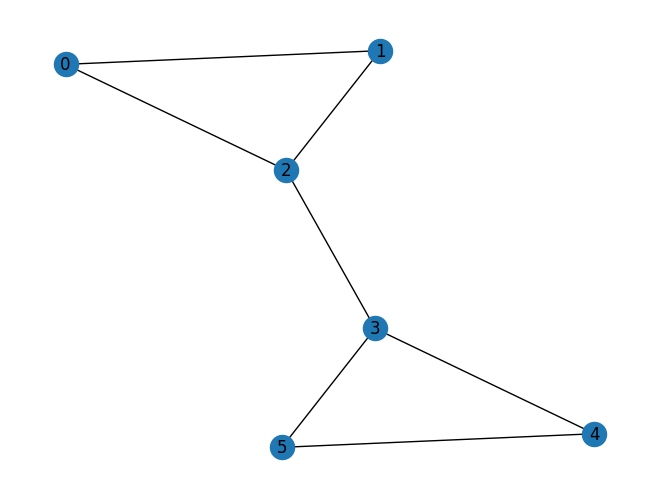

In [68]:
import networkx as nx

from qiskit_optimization.applications import Maxcut

seed = 12
num_nodes = 6



# G = nx.random_regular_graph(d=3, n=num_nodes, seed=seed)
# nx.draw(G, with_labels=True, pos=nx.spring_layout(G, seed=seed))


G = nx.Graph()
G.add_edges_from([(0,1),(1,2),(2,0),(3,2),(4,3),(5,3),(4,5)])
nx.draw_spring(G, with_labels=True)
maxcut = Maxcut(G)
problem = maxcut.to_quadratic_program()
print(problem.prettyprint())

In [69]:
# Initialize the weight matrix
w = np.zeros((num_nodes, num_nodes))

# Iterate over the edges of the graph and assign weights to the weight matrix
for edge in G.edges():
    node1, node2 = edge
    w[node1][node2] = 1
    w[node2][node1] = 1  # Assuming undirected graph

# Print the weight matrix
#print("Weight Matrix:")
#print(w)

In [70]:
import time
pos = nx.spring_layout(G)


Best solution = [1, 0, 0, 1, 0, 0] cost = 5.0
elapsed time = 0.010870695114135742 sec


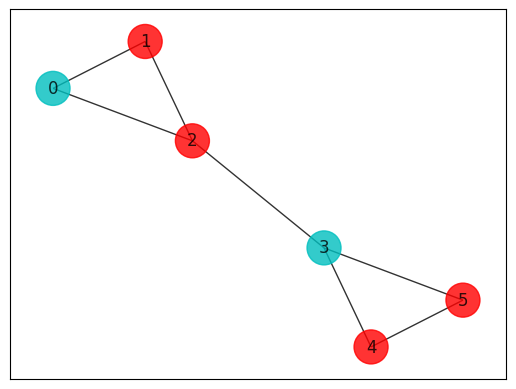

In [77]:
tic = time.time()
best_cost_brute = 0
for b in range(2**num_nodes):
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(num_nodes)))]
    cost = 0
    for i in range(num_nodes):
        for j in range(num_nodes):
            cost = cost + w[i, j] * x[i] * (1 - x[j])
    if best_cost_brute < cost:
        best_cost_brute = cost
        xbest_brute = x
    #print("case = " + str(x) + " cost = " + str(cost))

colors = ["r" if xbest_brute[i] == 0 else "c" for i in range(num_nodes)]
draw_graph(G, colors, pos)
print("\nBest solution = " + str(xbest_brute) + " cost = " + str(best_cost_brute))
toc = time.time()
print("elapsed time = " + str(toc - tic) + " sec")

In [78]:
max_cut = Maxcut(G)
qp = max_cut.to_quadratic_program()
print(qp.prettyprint())

Problem name: Max-cut

Maximize
  -2*x_0*x_1 - 2*x_0*x_2 - 2*x_1*x_2 - 2*x_2*x_3 - 2*x_3*x_4 - 2*x_3*x_5
  - 2*x_4*x_5 + 2*x_0 + 2*x_1 + 3*x_2 + 3*x_3 + 2*x_4 + 2*x_5

Subject to
  No constraints

  Binary variables (6)
    x_0 x_1 x_2 x_3 x_4 x_5



### Make a Hamiltonian out of it

In [79]:
qubitOp, offset = qp.to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(qubitOp))

Offset: -3.5
Ising Hamiltonian:
SparsePauliOp(['IIIIZZ', 'IIIZIZ', 'IIIZZI', 'IIZZII', 'IZZIII', 'ZIZIII', 'ZZIIII'],
              coeffs=[0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j])


In [80]:
# Problem to Hamiltonian operator
hamiltonian = qubitOp

In [81]:
print(hamiltonian)

SparsePauliOp(['IIIIZZ', 'IIIZIZ', 'IIIZZI', 'IIZZII', 'IZZIII', 'ZIZIII', 'ZZIIII'],
              coeffs=[0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j])


### Make the QAOA from ansatz

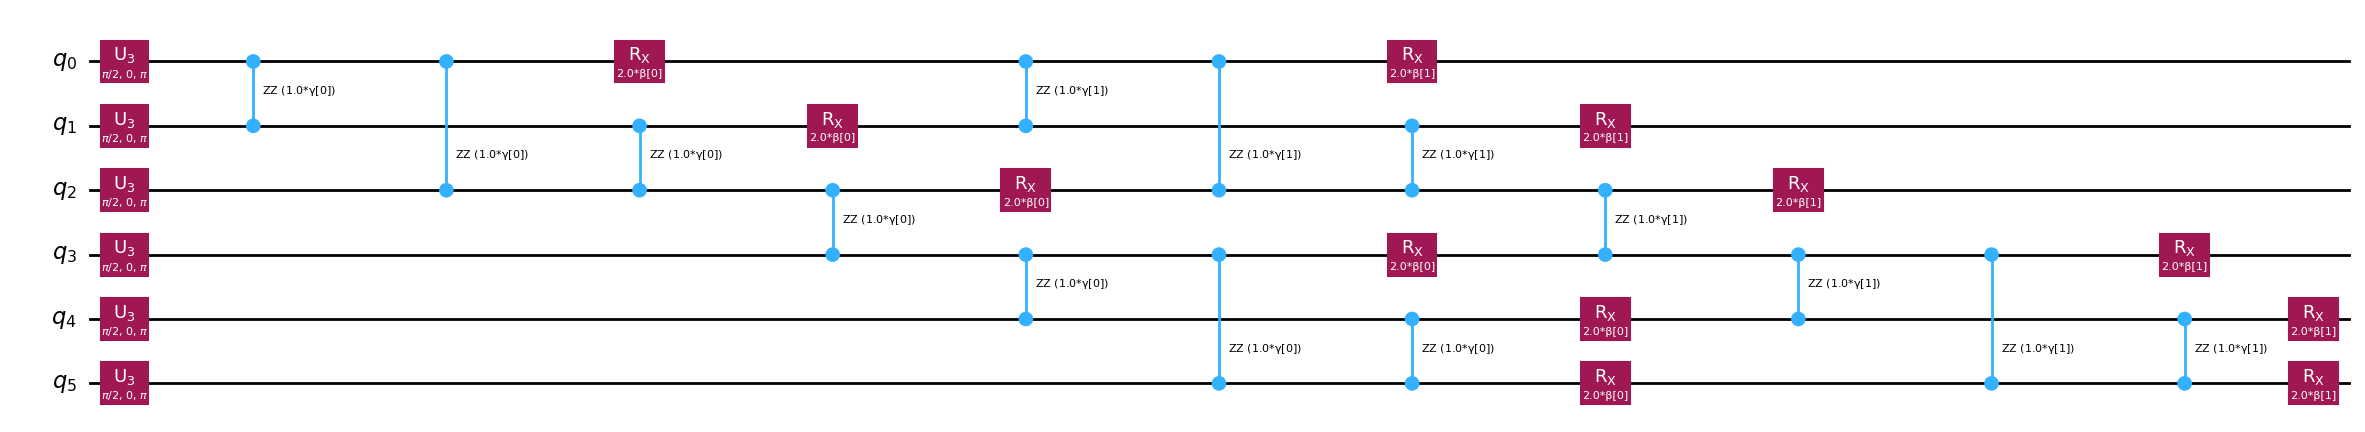

In [85]:
# QAOA ansatz circuit
ansatz = QAOAAnsatz(hamiltonian, reps=2)

ansatz.decompose(reps=3).draw(output="mpl", style="iqp",fold=-1)

In [86]:
ansatz.num_qubits

6

In [87]:
ansatz.num_parameters

4

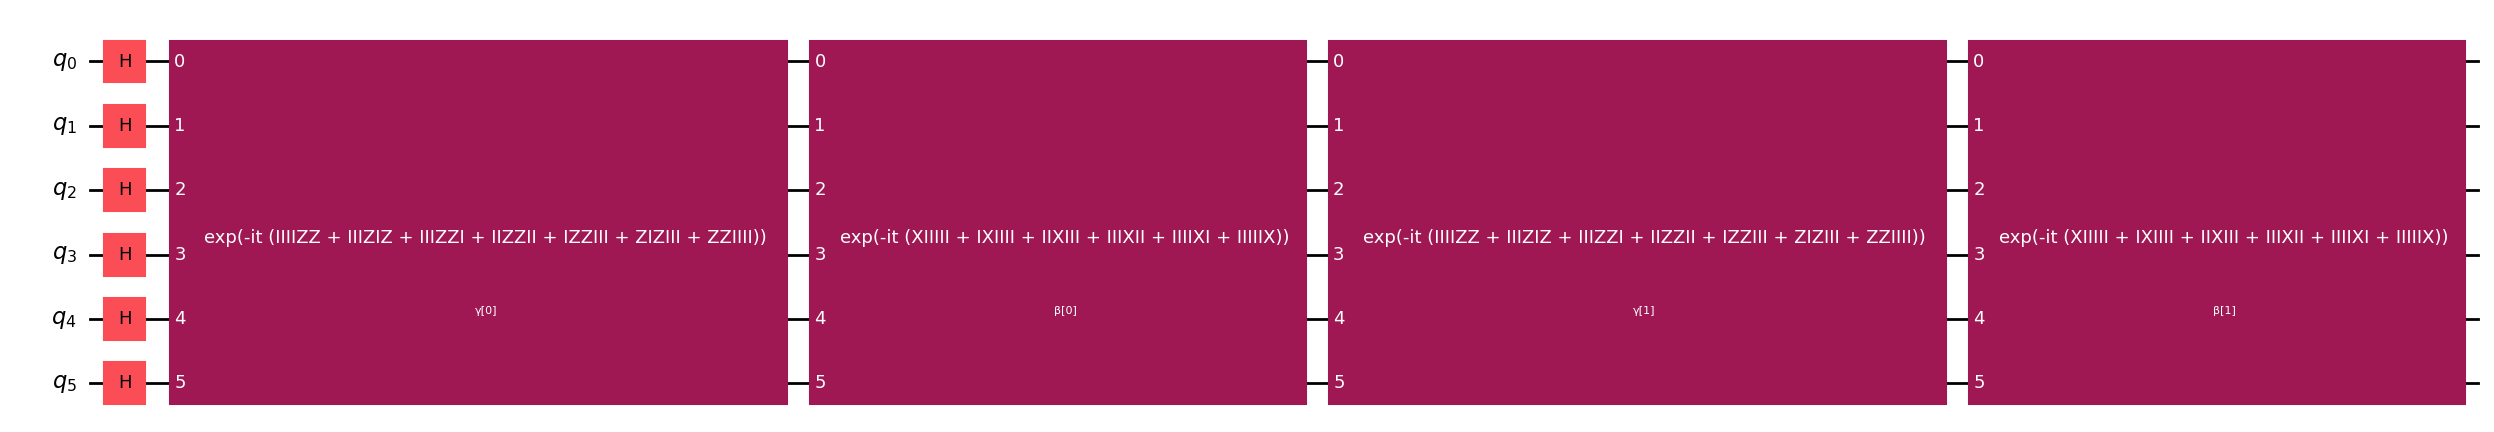

In [88]:
ansatz.decompose().draw(output="mpl", style="iqp",fold=-1)

### Run the Uncut Circuit

In [89]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    cost = estimator.run(ansatz, hamiltonian, parameter_values=params).result().values[0]
    return cost

In [90]:
Aer.backends()

[AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator'),
 QasmSimulator('qasm_simulator'),
 StatevectorSimulator('statevector_simulator'),
 UnitarySimulator('unitary_simulator')]

In [91]:
from qiskit_aer import Aer
from qiskit_aer.primitives import Sampler,Estimator
#Aer.backends()
from qiskit_aer import AerSimulator
#backend = Aer.get_backend('qasm_simulator')
backend = AerSimulator(method='statevector')

In [92]:
import qiskit
qiskit.__qiskit_version__

{'qiskit': '0.46.0', 'qiskit-aer': '0.13.3', 'qiskit-ignis': None, 'qiskit-ibmq-provider': '0.20.2', 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': '0.6.1', 'qiskit-machine-learning': '0.7.1'}

In [93]:
# To run on local simulator:
#   1. Use the Estimator from qiskit.primitives instead.
#   2. Remove the Session context manager below.

# options = Options()
# options.transpilation.skip_transpilation = True
# options.execution.shots = 10000



estimator = BackendEstimator(backend=backend)
sampler = BackendSampler(backend=backend)

In [94]:
x0 = 2 * np.pi * np.random.rand(ansatz.num_parameters)
print(x0)

[5.41307865 5.39070498 1.52490446 0.96803287]


In [95]:
print(x0)

[5.41307865 5.39070498 1.52490446 0.96803287]


In [96]:
tic = time.time()
res = minimize(cost_func, x0, args=(ansatz, hamiltonian, estimator), method="POWELL", options={"maxiter": 100})
toc = time.time()
print("elapsed time = " + str(toc - tic) + " sec")


elapsed time = 13.435384750366211 sec


1. $30$ qubits ~ $116$ minutes

In [97]:
res

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: -0.8056640625
       x: [ 7.410e+00  5.459e+00  1.792e+00  8.906e-01]
     nit: 6
   direc: [[ 1.000e+00  0.000e+00  0.000e+00  0.000e+00]
           [ 0.000e+00  1.000e+00  0.000e+00  0.000e+00]
           [ 0.000e+00  0.000e+00  1.000e+00  0.000e+00]
           [ 0.000e+00  0.000e+00  0.000e+00  1.000e+00]]
    nfev: 489

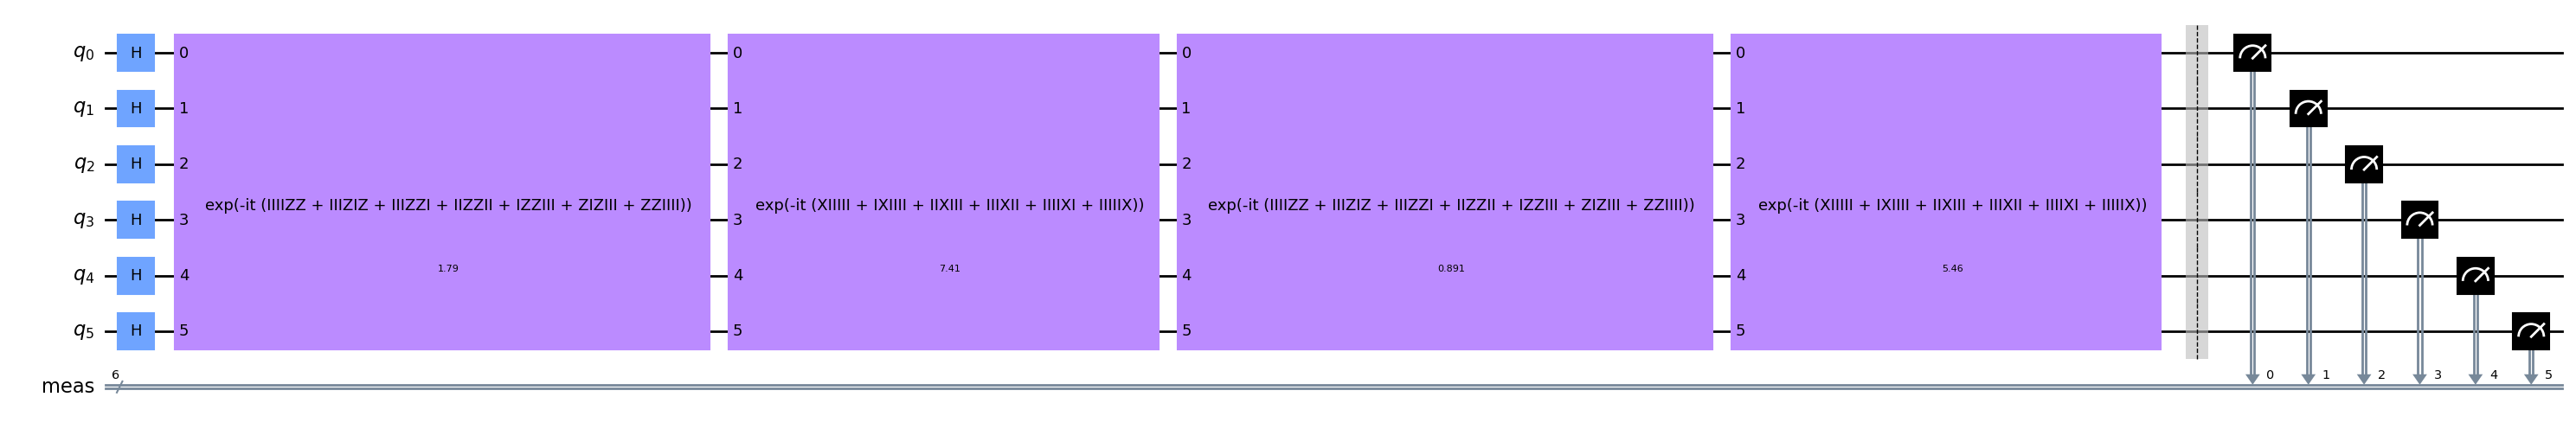

In [98]:
# Assign solution parameters to ansatz
qc = ansatz.assign_parameters(res.x)
# Add measurements to our circuit
qc.measure_all()
qc.decompose().draw(output="mpl",fold=-1)

In [99]:
# Sample ansatz at optimal parameters
samp_dist = sampler.run(qc).result().quasi_dists[0]
my_dict = dict(sorted(samp_dist.binary_probabilities().items(),key=lambda item: item[1], reverse=True))
#my_dict = samp_dist.binary_probabilities()
print(my_dict)

{'100101': 0.05078125, '011010': 0.0498046875, '100110': 0.044921875, '010110': 0.044921875, '101001': 0.0419921875, '010101': 0.0390625, '011001': 0.0380859375, '101010': 0.033203125, '100001': 0.0322265625, '011110': 0.03125, '010010': 0.0302734375, '010001': 0.02734375, '101110': 0.0263671875, '011101': 0.0244140625, '100010': 0.0244140625, '001101': 0.0234375, '011100': 0.0234375, '110011': 0.0224609375, '001110': 0.0224609375, '101101': 0.0205078125, '101011': 0.0205078125, '110001': 0.01953125, '101100': 0.01953125, '110010': 0.01953125, '100011': 0.0185546875, '001100': 0.0166015625, '100100': 0.0166015625, '000110': 0.015625, '110101': 0.015625, '110110': 0.0146484375, '010011': 0.0146484375, '011000': 0.013671875, '101000': 0.013671875, '111001': 0.013671875, '000101': 0.009765625, '110100': 0.009765625, '100111': 0.0087890625, '010100': 0.0078125, '111010': 0.0078125, '001011': 0.0078125, '001001': 0.0078125, '011011': 0.0068359375, '001010': 0.0068359375, '010111': 0.0048828

In [100]:
print("Brute Force Solution: ", xbest_brute)
# first result from my_dict
print("QAOA Solution: ", list(my_dict.keys())[0])

Brute Force Solution:  [1, 0, 0, 1, 0, 0]
QAOA Solution:  100101


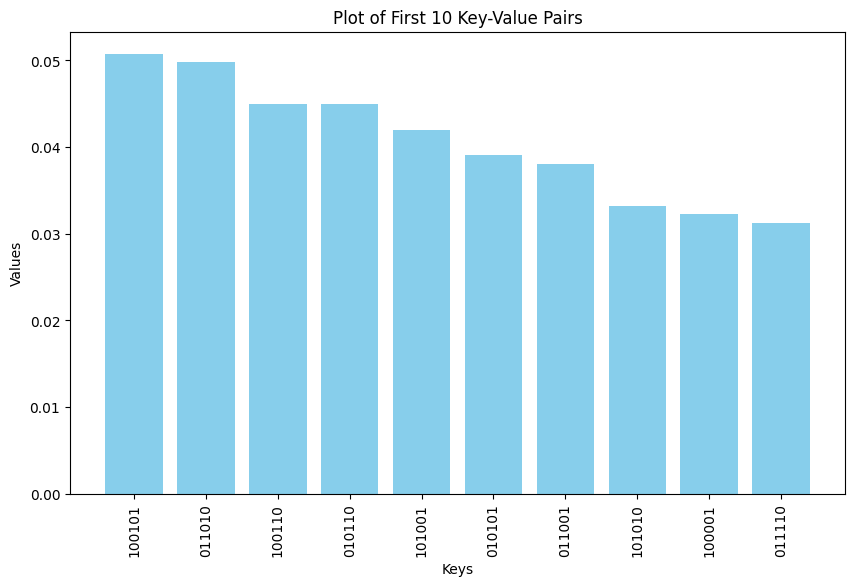

In [101]:
# plot the histogram of my_dict, for only first 10 elements
# Extract first 10 key-value pairs
first_10_items = list(my_dict.items())[:10]
x_values = [item[0] for item in first_10_items]
y_values = [item[1] for item in first_10_items]

# Plot the data
plt.figure(figsize=(10, 6))
plt.bar(x_values, y_values, color='skyblue')
plt.xlabel('Keys')
plt.ylabel('Values')
plt.title('Plot of First 10 Key-Value Pairs')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()

## Wire Cutting

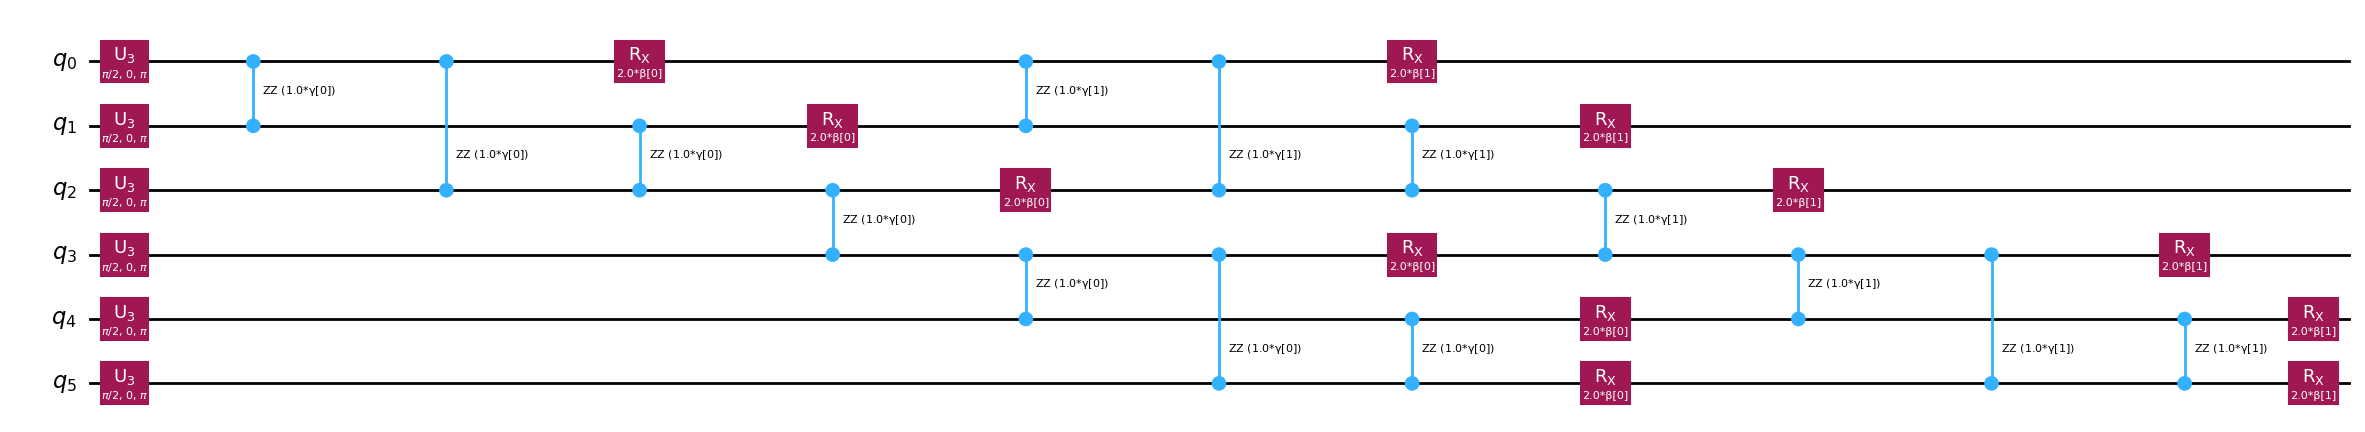

In [103]:
# QAOA ansatz circuit
ansatz = QAOAAnsatz(hamiltonian, reps=2)

ansatz.decompose(reps=3).draw(output="mpl", style="iqp",fold=-1)

In [104]:
ansatz.num_parameters

4

### Transpile it, so that it's easy to cut

In [105]:
from qiskit import transpile

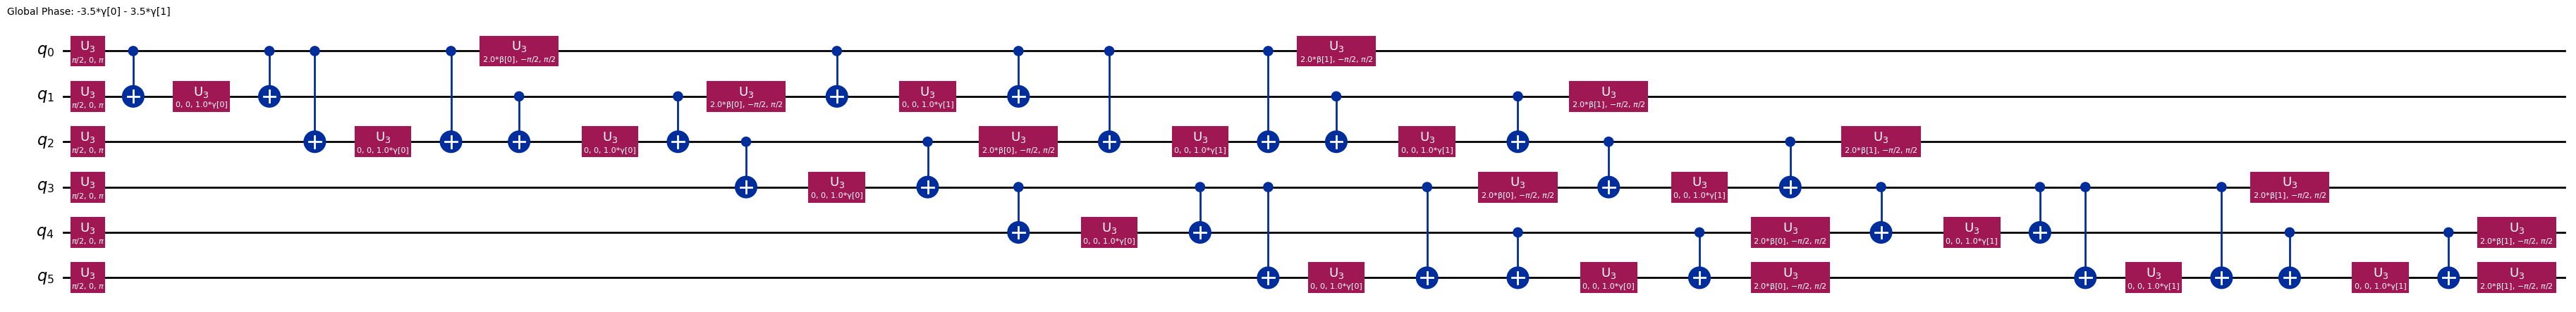

In [106]:
circuit_basis = transpile(ansatz, basis_gates=['u3', 'cx'], optimization_level=3)
circuit_basis.draw(output="mpl", style="iqp",fold=-1)

### Invoke the Wire Cutting

```python
cuts = cut_circuit_wires(
    circuit=circuit_basis,
    method="automatic",
    max_subcircuit_width=8,
    max_cuts=400,
    num_subcircuits=[4],
)
```

In [ ]:
%%capture

from circuit_knitting.cutting.cutqc import cut_circuit_wires

cuts = cut_circuit_wires(
    circuit=circuit_basis,
    method="automatic",
    max_subcircuit_width=4,
    max_cuts=400,
    num_subcircuits=[2],
)

In [ ]:
# visualize the first subcircuit
cuts["subcircuits"][0].draw("mpl",style='iqx', fold=-1, scale=0.6)

KeyError: 'subcircuits'

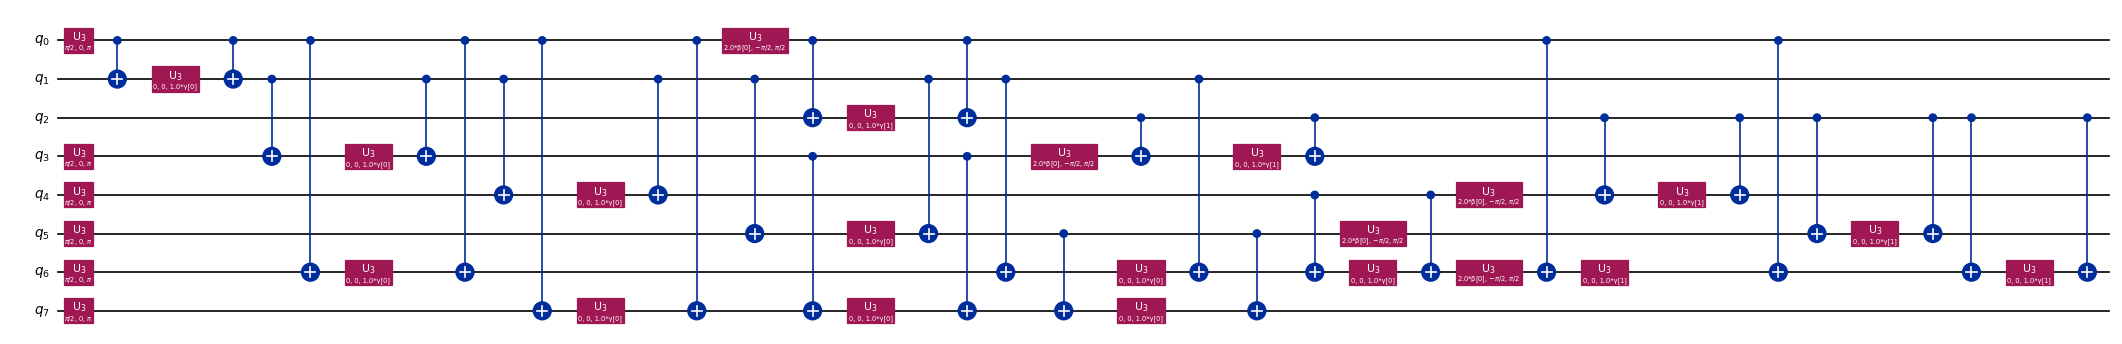

In [ ]:
# visualize the second subcircuit
cuts["subcircuits"][1].draw("mpl",style='iqx', fold=-1, scale=0.6)

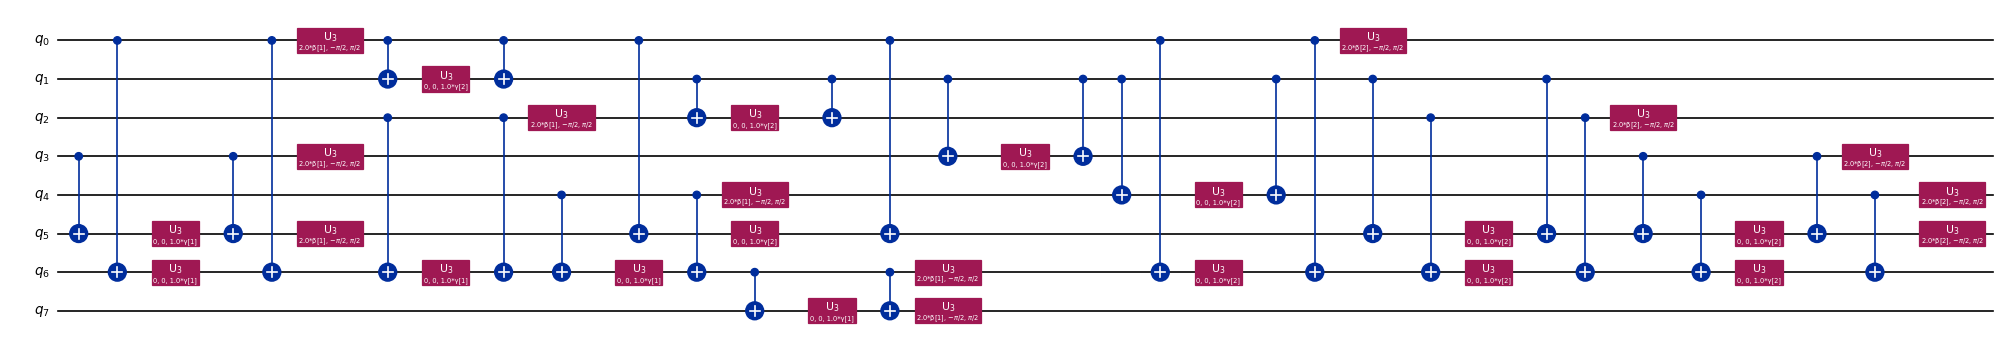

In [ ]:
# visualize the second subcircuit
cuts["subcircuits"][2].draw("mpl",style='iqx', fold=-1, scale=0.6)

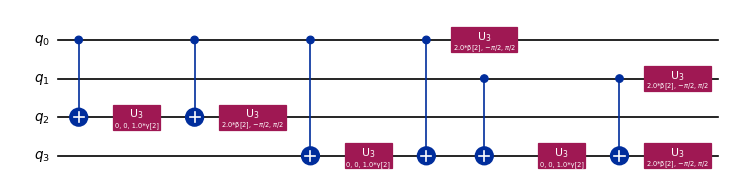

In [ ]:
# visualize the second subcircuit
cuts["subcircuits"][3].draw("mpl",style='iqx', fold=-1, scale=0.6)

## Evaluate the Subcircuits

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService  # noqa: F401

# Use local versions of the primitives by default.
service = None

# Uncomment the following line to instead use Qiskit Runtime Service.
# service = QiskitRuntimeService()

### Configure the runtime Primitive

In [ ]:
from qiskit_ibm_runtime import Options

# Set the Sampler and runtime options
options = Options(execution={"shots": 4000})

# Run 2 parallel qasm simulator threads
backend_names = ["ibmq_qasm_simulator"] * 4

## Evaluate on backends

In [ ]:
from circuit_knitting.cutting.cutqc import evaluate_subcircuits

subcircuit_instance_probabilities = evaluate_subcircuits(cuts)

# Uncomment the following lines to instead use Qiskit Runtime Service as configured above.
# subcircuit_instance_probabilities = evaluate_subcircuits(cuts,
#                                                          service_args=service.active_account(),
#                                                          backend_names=backend_names,
#                                                          options=options,
#                                                         )

## Inspecting the Subcircuit Results

In this case the original circuit was cut   times, you can get that information by:

In [ ]:
print("Total number of cuts: ",cuts['num_cuts'])
print("Number of subcircuits: ",len(cuts['subcircuits']))
# or can do
print("Number of subcircuits: ",len(subcircuit_instance_probabilities))

For these     wire cuts, there are $4^{} =  $ variants of the first subcircuit, and similary $4^{} = $ variants for the second, similarly for the third and same for fourth

In [ ]:
print(
    "Number of variants of 1st subcircuit: ", len(subcircuit_instance_probabilities[0])
)
print(
    "Number of variants of 2nd subcircuit: ", len(subcircuit_instance_probabilities[1])
)
print(
    "Number of variants of 3rd subcircuit: ", len(subcircuit_instance_probabilities[2])
)
print(
    "Number of variants of 4th subcircuit: ", len(subcircuit_instance_probabilities[3])
)

## Best Cut

Found solution using 2 cuts with a sampling overhead of 256.0.
Wire Cut at index 31
Wire Cut at index 40


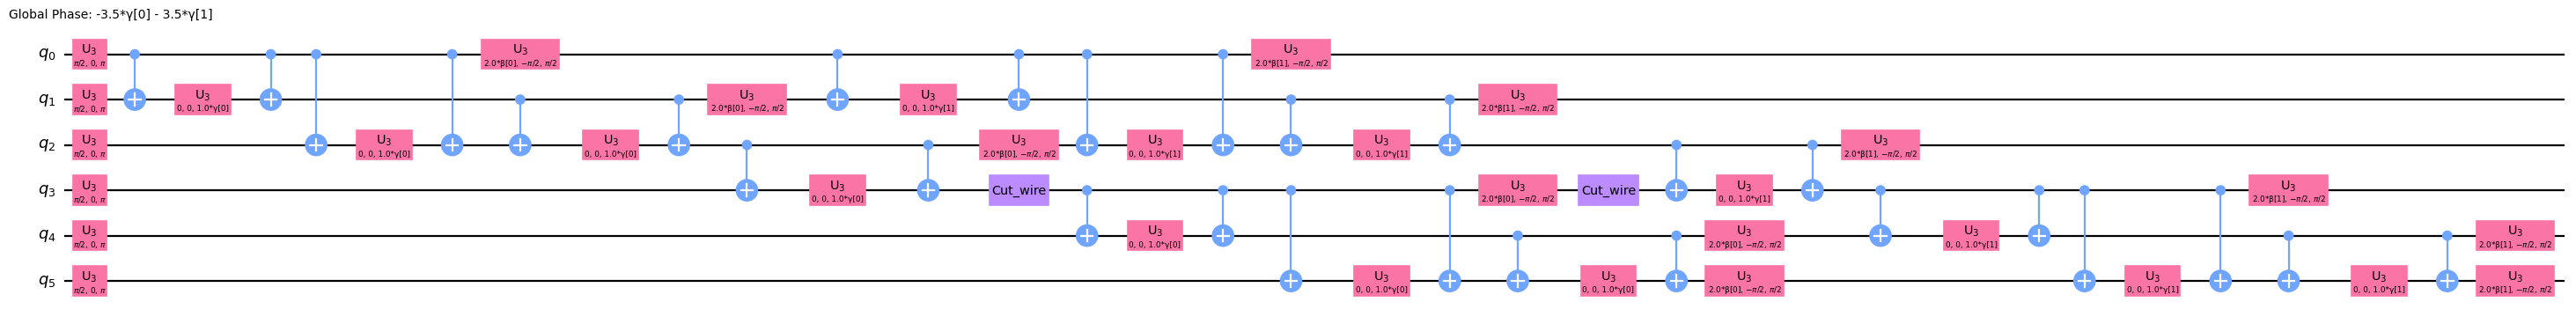

In [107]:
from circuit_knitting.cutting import find_cuts

# Specify settings
optimization_settings = {"rand_seed":111}

# specify device constraints
device_constraints = {"qubits_per_QPU": 4, "num_QPUs": 2}


cut_circuit, metadata = find_cuts(circuit_basis, optimization_settings, device_constraints)
print(
    f'Found solution using {len(metadata["cuts"])} cuts with a sampling '
    f'overhead of {metadata["sampling_overhead"]}.'
)
for cut in metadata["cuts"]:
    print(f"{cut[0]} at index {cut[1]}")
cut_circuit.draw("mpl", scale=0.8, fold=-1)

In [108]:
print(hamiltonian)

SparsePauliOp(['IIIIZZ', 'IIIZIZ', 'IIIZZI', 'IIZZII', 'IZZIII', 'ZIZIII', 'ZZIIII'],
              coeffs=[0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j])


In [109]:
from qiskit.quantum_info import PauliList
observables = PauliList(['IIIIZZ', 'IIIZIZ', 'IIIZZI', 'IIZZII', 'IZZIII', 'ZIZIII', 'ZZIIII'])
print(observables)

['IIIIZZ', 'IIIZIZ', 'IIIZZI', 'IIZZII', 'IZZIII', 'ZIZIII', 'ZZIIII']


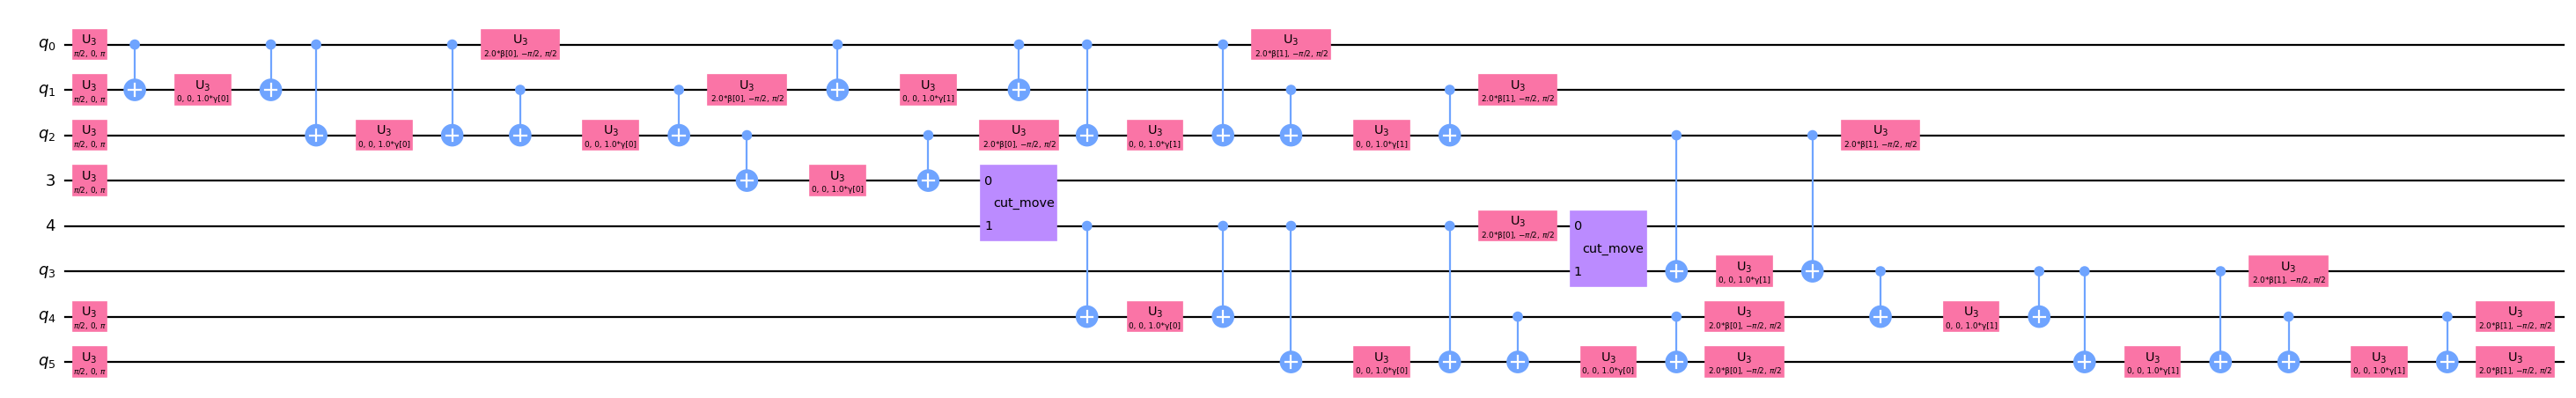

In [110]:
from circuit_knitting.cutting import cut_wires, expand_observables

qc_w_ancilla = cut_wires(cut_circuit)
observables_expanded = expand_observables(observables, circuit_basis, qc_w_ancilla)
qc_w_ancilla.draw("mpl", scale=0.8, fold=-1)

In [111]:
from circuit_knitting.cutting import partition_problem

partitioned_problem = partition_problem(
    circuit=qc_w_ancilla, observables=observables_expanded
)
subcircuits = partitioned_problem.subcircuits
subobservables = partitioned_problem.subobservables
print(
    f"Sampling overhead: {np.prod([basis.overhead for basis in partitioned_problem.bases])}"
)


Sampling overhead: 256.0


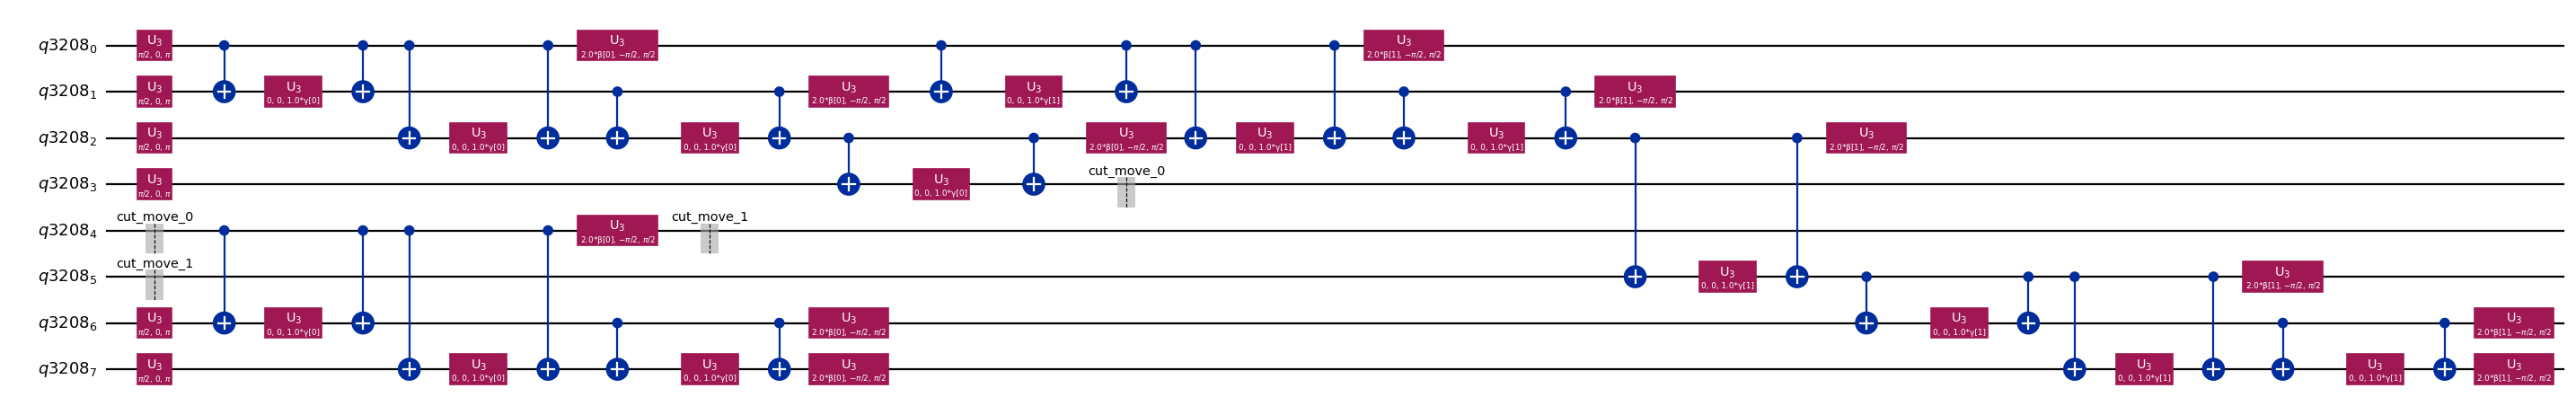

In [112]:
subcircuits[0].draw("mpl", style="iqp", scale=0.8,fold=-1)